# Image Denoising with Stan

# What is Stan?

Stan is a probabilistic programming language that is used to estimate parameters from complex distributions and from complex hierarchichal Bayesian models, respectively. The parameters are estimated by approximate inference based on Markov-Chain-Monte-Carlo sampling. In particular, Stan utilizes the a Hamiltonian Monte Carlo (HMC) approach that can intuitively be viewed as sampling from probability distributions by traversing the potential energy landscape with a particle that gets a random kinetic energy for every sample. This is equivalent to using gradient information to move along the potential energy landscape. As other MCMC methods (e.g. Metropolis-Hastings) the HMC scheme is based on an accept-reject scheme, where the acceptance criteria for a sample is the ratio between the proability at the new point compared to the probability value at the previous point. This leads to an acceptance probability of 100% when the new value is larger than the previous value.

Additionally, Stan implements what is called the No-U-Turn sample, which makes it particularly efficient because the sampler automatically chooses the right parameters, i.e. the step size and number of steps (leap-frog steps) in the space of the potential landscape (https://arxiv.org/pdf/1111.4246.pdf). Stan is particularly efficient and converges orders of magnitude faster than comparable tools (JAGS, BUGS), especially for complicated hierarchical Bayesian models. The advantage of Stan lies in the superiority of HMC + No-U-turn compared to more traditional Gibbs-sampling or Metropolis-Hastings sampling methods.

For an animation of the different MCMC-sampling methods see:
https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,banana

In terms of implementation, Stan is a self-contained programming language. Hence, it features all the standard expressions such as conditional statements, loops, function definitions and so on. Stan is a compiled language, the Stan code is compiled into C++.

In [209]:
# Libraries ---------------------------------------------------------------
library(jpeg)
library(imager)
library(purrr)
library(ggplot2)
library(rstan)
library(dplyr)
library(tidyr)
library(repr)
options(repr.plot.width=6, repr.plot.height=4)

# Linear Regression with Stan

### Create Random Data

Data are generated as

$$
y \sim \mathcal{N} (\alpha + \beta x, \sigma)
$$

with true values 

$$
\alpha = 4.0 \\
\beta = 0.5 \\
\sigma = 1.0 
$$

So let us create some data points in the interval $x \in [0, 10]$.

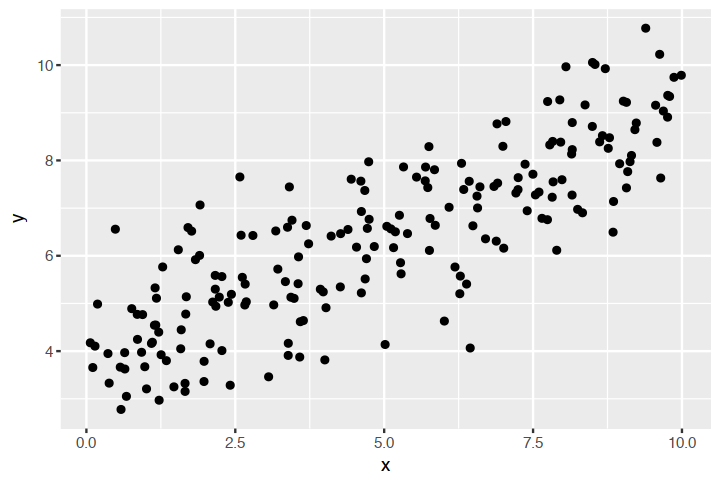

In [211]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0
N = 200

# Generate and plot data
x = 10 * runif(n = N)
y = alpha + beta * x
y = rnorm(N, mean = y, sd = sigma)
data <- tibble(x=x,y=y)

ggplot(data = data, aes(x = x, y = y)) + 
    geom_point()

### Defining the Stan model

A Stan model requires at least 3 blocks:
- Data block
- Parameters block
- Model block

In [212]:
lr_model <- "
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"

### Compile model

In [213]:
lr_stan <- stan_model(model_code=lr_model)

### Feed Data and sample
Sampling parameters:
- iter: Number of total sampling iterations
- chains: Number of chains that will be sampled from different starting points (several localized optima)
- warmup: 'burn-in' only samples after that will be considered. Stationarity!
- thin: discard every n-th sample due to correlations

In [214]:
# Define data
data_list<-list(
    x = x,
    y = y,
    N = length(x)
)

In [215]:
# Sample
lr_stan_fit <- sampling(
    object=lr_stan , 
    data = data_list , 
    chains = 3,
    iter = 1000, 
    warmup = 200, 
    thin = 1
)


SAMPLING FOR MODEL '9e2e35087ad74affc06fc53453a5a971' NOW (CHAIN 1).

Gradient evaluation took 0.000623 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.23 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 201 / 1000 [ 20%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.744433 seconds (Warm-up)
               2.00265 seconds (Sampling)
               2.74709 seconds (Total)


SAMPLING FOR MODEL '9e2e35087ad74affc06fc53453a5a971' NOW (CHAIN 2).

Gradient evaluation took 0.000212 seconds
1000 transitions using 10 leapfrog steps 

### Plot information about the parameter $\beta$

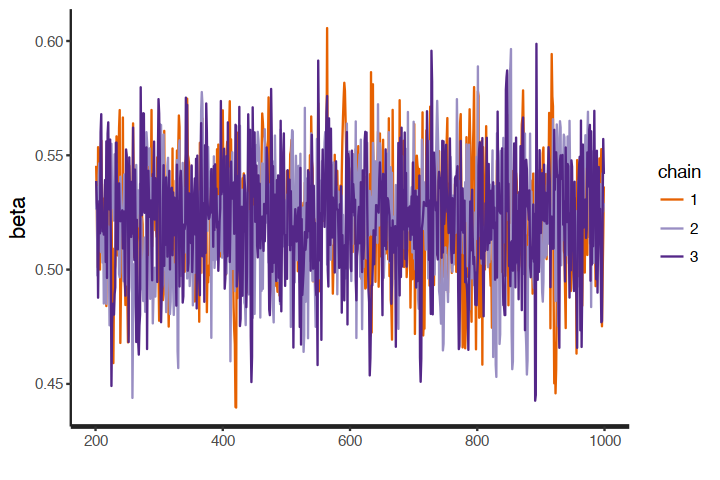

In [216]:
stan_trace(lr_stan_fit, pars=c("beta"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


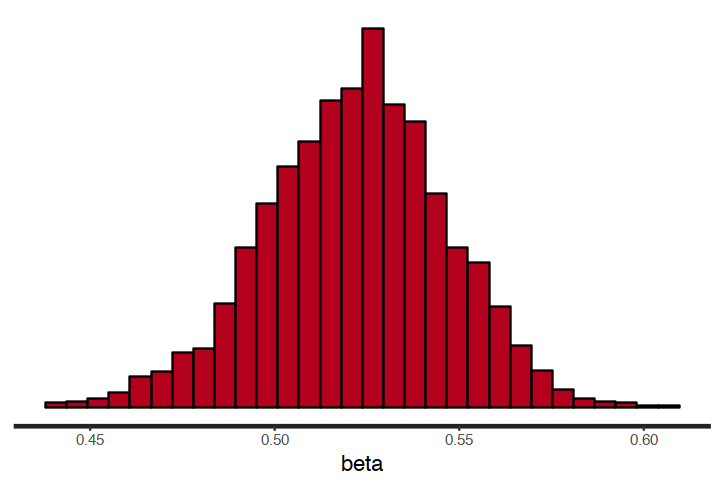

In [217]:
stan_hist(lr_stan_fit, pars=c("beta"))

### Summary of parameters

In [218]:
S <- summary(lr_stan_fit)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.801,0.004,0.140,3.532,3.709,3.796,3.893,4.080,1346.185,0.999
beta,0.522,0.001,0.025,0.470,0.506,0.523,0.538,0.569,1355.424,1.001
sigma,1.014,0.001,0.050,0.925,0.978,1.010,1.045,1.119,1407.111,1.001
lp__,-102.200,0.040,1.205,-105.431,-102.775,-101.858,-101.301,-100.812,930.816,1.001


In [220]:
df_lr_stan <- as.data.frame(lr_stan_fit)
lr_stan_alpha <- mean(df_lr_stan$alpha)
lr_stan_beta <- mean(df_lr_stan$beta)
lr_stan_sigma <- mean(df_lr_stan$sigma)

y_stan <- function(x) lr_stan_alpha + x*lr_stan_beta

data_stan <- tibble(x = x) %>% 
    mutate(y = y_stan(x))

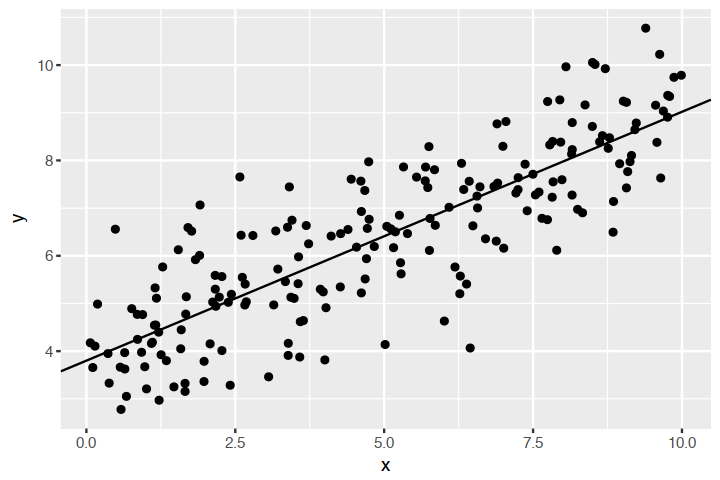

In [221]:
ggplot(data = data, aes(x = x, y = y)) + 
    geom_point() +
    geom_abline(intercept = lr_stan_alpha, slope = lr_stan_beta)

# Image Denoising

In [285]:
options(repr.plot.width=5, repr.plot.height=5)

In [286]:
# Load data
img_noise <- grayscale(load.image("greyscale.png"))
img_noisefree <- img_noise

In [287]:
rnorm_noise <- function(x, sigma){
    output <- rnorm(n = 1, mean = x, sd = sigma)
    if(output > 1){
        output <- 1
    } else if (output < 0) {
        output <- 0
    } 
    return(output)
}

img_noise[] <- apply(img_noise, 1:2, rnorm_noise, 0.1)

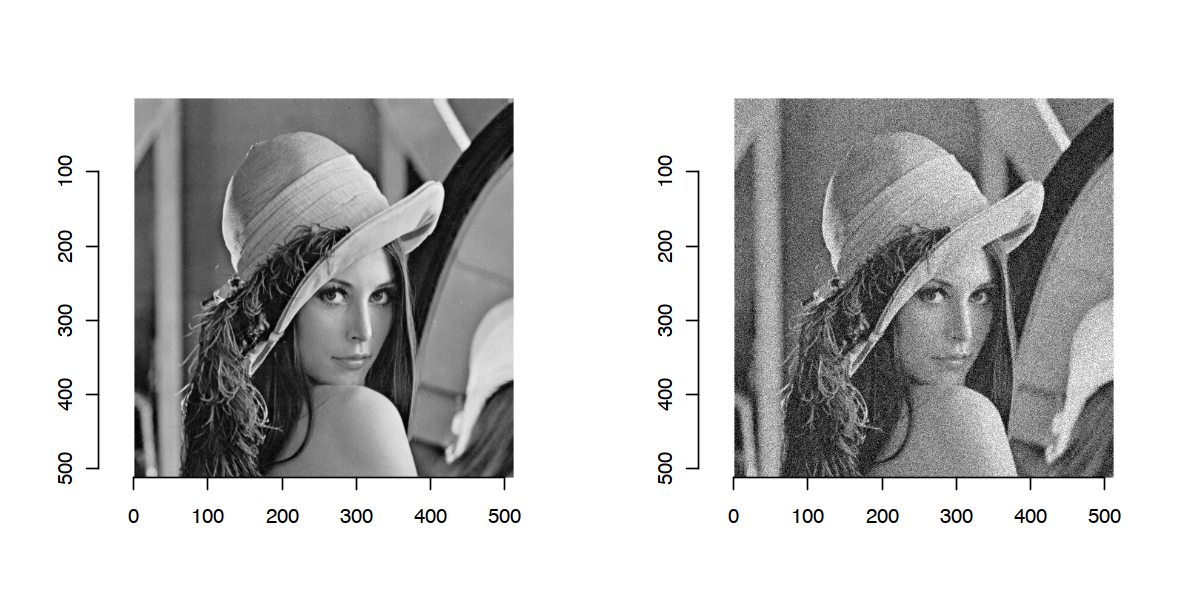

In [288]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(img_noisefree)
plot(img_noise)

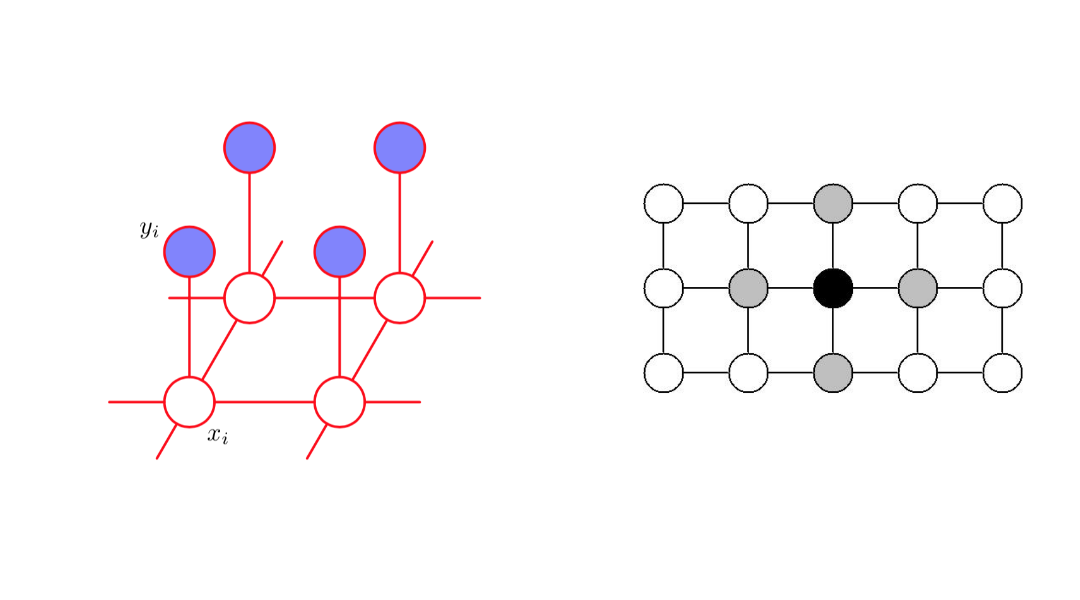

In [289]:
markov2d <- load.image("MarkovNetwork2d.png")
markov <- load.image("MarkovNetwork.png")

options(repr.plot.width=9, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(markov, axes = FALSE)
plot(markov2d, axes=FALSE)

### Energy function

We have the observed points $y_i$ which are the noisy image, and we want to find the unobserved $x_i$ which represent the underlying real image. The values of $x_i$ and $y_i$, respectively, are the pixel values of the observed/unobserved image.

We model this as a Markov Network with an associated energy function

$$
E(x, y) = \sum_i V_i(x_i, y_i) + \sum_{\{i, j\}} V_{ij}(x_i, x_j).
$$

The former potential energy

$$
V_i(x_i, y_i) = \frac{(x_i - y_i)^2}{2\sigma^2}
$$

is associated to the first summand can be seen as the **likelihood** of the Bayesian model, where summation is performed over **all pixels**. $\sigma$ represents the standard deviation of the noise assuming that the noise generation process is underlying a **Gaussian noise distribution**.

The latter potential energy

$$
V_{ij}(x_i, x_j) = \gamma min((x_i - x_j)^2, \beta).
$$

can be considered as the **prior** of the unobserved pixel values of the real image. Importantly, the summation runs over all i but only over those j that fulfill $|i-j|=1$, i.e. **neighboring pixels**. 

To achieve image denoising, one wants to **minimze the energy**, which meanse that neighboring pixels ideally would have the same magnitude. Any difference between neighboring pixels would lead to an increase in energy, as well as differences between observed pixels and latent pixels at position $i$. Therefore, one needs to find the right mix of parameters $\sigma$, $\gamma$, and $\beta$. Specifically, $\gamma$ specifies the ratio of observed versus neighboring pixels, and $\beta$ represents a maximum energy punishment between neighboing pixels. The latter is introduced in order to allow edges in the image.

### Joint probability distribution
Encoding the energy in terms of a joint probability distribution we have

$$
p(x, y) = \frac{1}{Z} exp(-E(x, y)).
$$

As mentioned before, we want to minimize the energy to obtain an ideally denoised image, which is equivalent to maximizing the probability. This can simply be formulated as a maximum-(log)-likelhood problem, so we finally feed

$$
log~p(X|Y) \propto - \sum_i \frac{(x_i - y_i)^2}{2\sigma^2} - \sum_{\{i, j\}} \gamma min((x_i - x_j)^2, \beta)
$$

into Stan, and use Stan's optimization capabilities.

### Stan model

In [290]:
stan_string <- "
functions {
    real log_likelihood(matrix X, real sigma, matrix Y, int k, int l){
        real likelihood = pow(X[k,l] - Y[k,l], 2)/(2*pow(sigma, 2));
        return likelihood;
    }

    real log_prior(matrix X, real b, real g, matrix Y, int k, int l){

        real low = g*(fmin(pow(X[k,l] - X[k, l+1], 2), b));
        real up = g*(fmin(pow(X[k,l] - X[k, l-1], 2), b)); 
        real left  = g*(fmin(pow(X[k,l] - X[k-1, l], 2), b)); 
        real right = g*(fmin(pow(X[k,l] - X[k+1, l], 2), b));
        
        return low + up + left + right;
    }

    real phi(matrix X, real s, real b, real g, matrix Y, int k, int l) {
        real posterior;
        posterior = -(log_likelihood(X, s, Y, k, l) + log_prior(X, b, g, Y, k, l));
        return posterior;
    }

    real phi_sum_log(matrix X, real s, real b, real g, matrix Y, int m, int n){
        matrix[m,n] prob;
        real lprob;

        for (k in 1:m) {
            for (l in 1:n){
                if (l == 1 || l == n || k == 1 || k == m){
                    prob[k,l] = 0;
                } else {
                    prob[k,l] = phi(X, s, b, g, Y, k, l);
                }
            }
        }

        lprob = sum(prob);
        return lprob;
    }

}

data {
    int m;
    int n;
    real g;
    real b;
    real s;
    matrix<lower=0,upper=1>[m, n] Y;
}
parameters {
    matrix<lower=0,upper=1>[m, n] X;
}
model {
    X ~ phi_sum(s, b, g, Y, m, n);
}
"

stan_model_joint <- stan_model(model_code = stan_string)

### Optimization in Stan

In [291]:
Y <- matrix(img_noise, dim(img_noise)[1], dim(img_noise)[2])

rows = nrow(Y)
cols = ncol(Y)
incr = 1

#Y <- matrix(img_noise, dim(img_noise)[1], dim(img_noise)[2])[incr:(incr+rows-1), incr:(incr+cols-1)]

image_data <- list(
    s = 0.15,
    b = 0.1,
    g = 50,
    m = rows,
    n = cols,
    Y = Y[1:rows, 1:cols]
) 

opti <- optimizing(stan_model_joint, 
                   data = image_data, 
                   verbose = TRUE)$par

Initial log joint probability = -3.56569e+06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -101405       8.47923       827.218      0.7246      0.7246       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -74594.6       1.94253       137.454      0.5533      0.5533       41   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -73811.8         1.565       89.4221       0.148           1       65   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79      -73619.8      0.282575       5.16592           1           1       93   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -73575.3      0.184832       2.95546           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alp

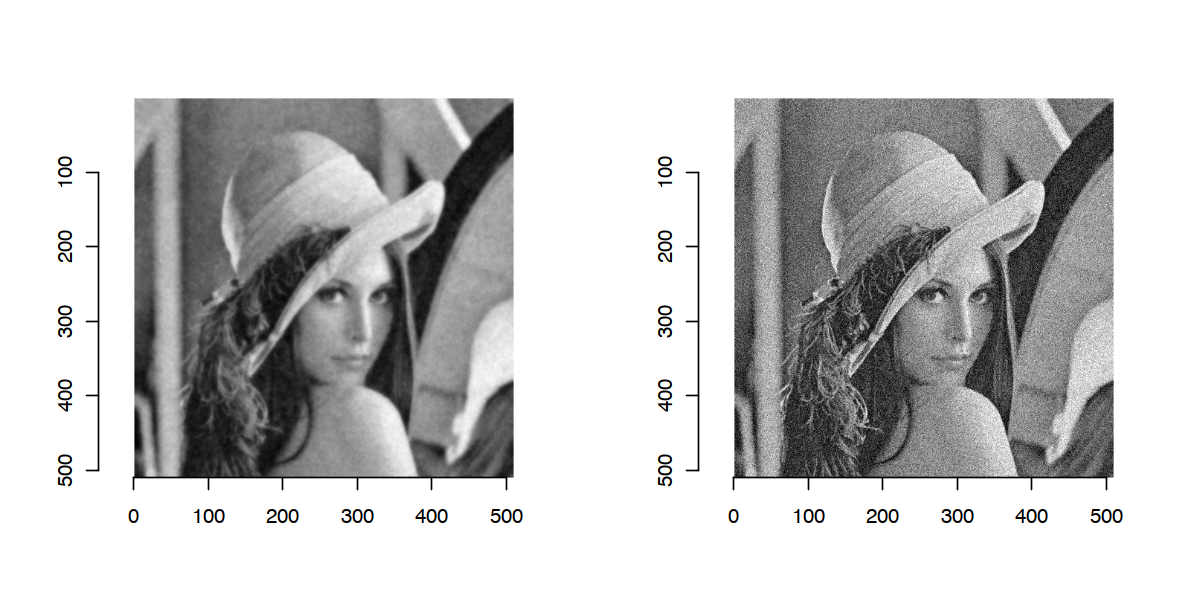

In [292]:
optimatrix = matrix(opti, nrow = rows, ncol = cols)

options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(as.cimg(optimatrix[2:(rows-1),2:(cols-1)]))
plot(as.cimg(Y[2:(rows-1),2:(cols-1)]))